# Advanced Lane Finding Project 

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  


### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point. 

You're reading it!

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.


I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `obj_points` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `img_points` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `obj_points` and `img_points` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` and use `cv2.getPerspectiveTransform` and `cv2.warpPerspective` functions to perform perspective transform the images. The sample results are in the end of this section. All the code are as below. 

        

### Imports

In [32]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob 
import os 

Use Opencv to find corners of all the images under folder `camera_cal`

In [21]:
nx = 9
ny = 6
CALIB_IMG_PATH = 'camera_cal/*jpg'
CALIB_OUT_IMG_PATH = 'output_images/chessboard_calib_output/'
calib_img_files = glob.glob(CALIB_IMG_PATH)


# Array to store images used in camera calibration
image_names   = []
images        = []
failed_images = [] # Images we could not find corners 
failed_image_names = [] # Images we could not find corners 

obj_points  = [] # 3D points in real world 3D space  
img_points  = [] # 2D points in image space 

objp = np.zeros((nx*ny, 3), dtype= np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)


for img_file in sorted(calib_img_files):
    image = cv2.imread(img_file)
    gray  = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    name  = img_file.split('/')[-1]
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    if ret:
        image_names.append(name)
        images.append(image)
        img_points.append(corners)
        obj_points.append(objp)
        # draw and display corners
#         image_copy = np.copy(image)
#         cv2.drawChessboardCorners(image_copy, (nx,ny), corners, ret)
        # plt.imshow(image)
        # plt.show()
    else:
        print('Unable to find board corners for image ' + name)
        failed_images.append(image)
        failed_image_names.append(name)
    

Unable to find board corners for image calibration1.jpg
Unable to find board corners for image calibration4.jpg
Unable to find board corners for image calibration5.jpg


As you can see from above prints, we could not find corners from some images. I displayed the those images below and you can see that those images were not properly taken and part of the chessboard are missing. As we request opencv to find `nx=9 * ny=6` corners, it does not suprise me that it fails here. 

### Draw corners on images

We successfully detected `nx*ny` corners in most of chessboard images. Now let's draw the detected corners on those image to make sure the results are correct.


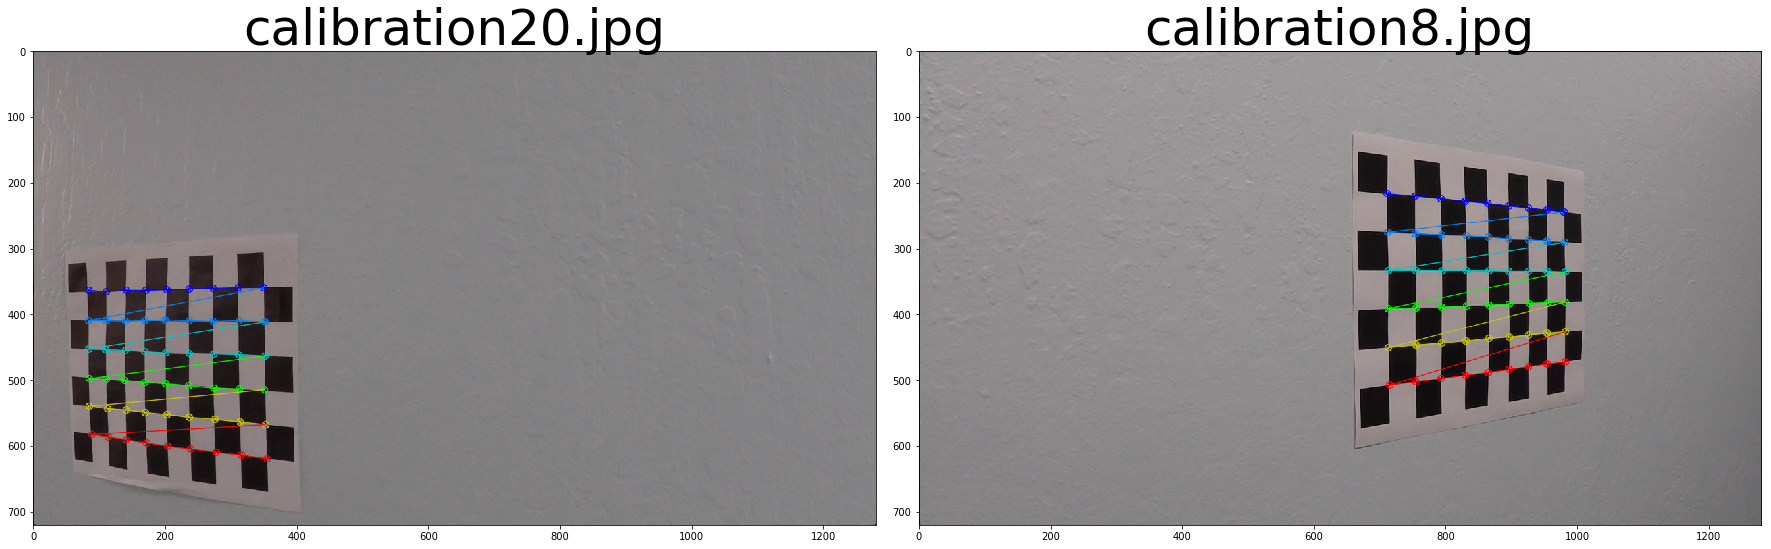

In [3]:
# Draw corners on chessboard images
# Randomly select 2 chessboard images and draw corners on it 
img_idxs = np.random.choice(len(images), 2)

img1 = np.copy(images[img_idxs[0]])
img2 = np.copy(images[img_idxs[1]])

cv2.drawChessboardCorners(img1, (nx,ny), img_points[img_idxs[0]], True)
cv2.drawChessboardCorners(img2, (nx,ny), img_points[img_idxs[1]], True)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img1)
ax1.set_title(image_names[img_idxs[0]], fontsize=50)

ax2.imshow(img2)
ax2.set_title(image_names[img_idxs[1]], fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()



### Show failed images

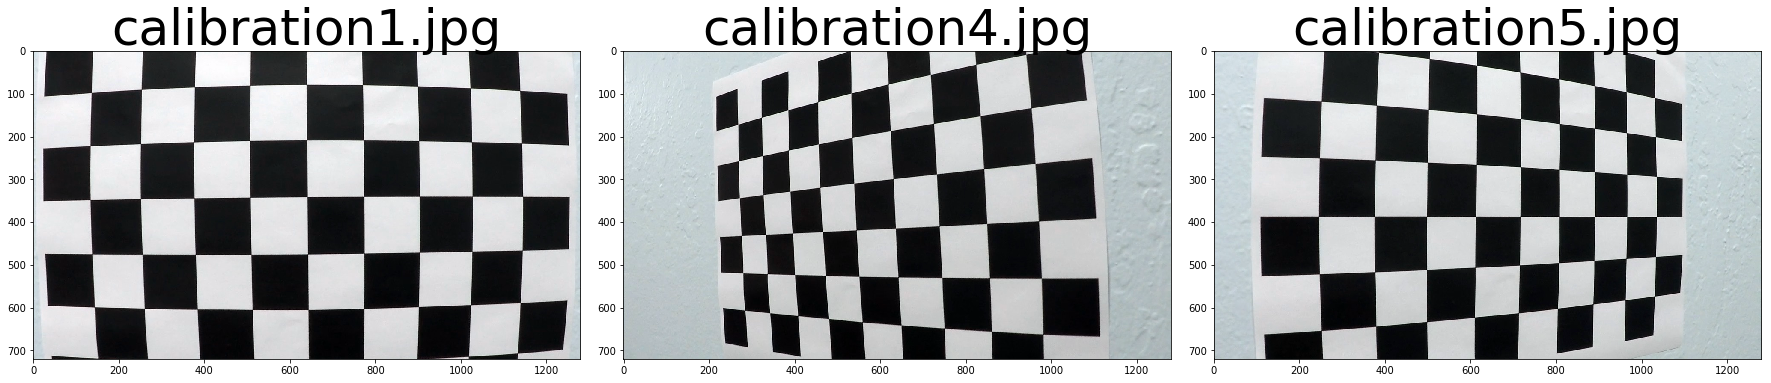

In [4]:
# Display chess board images which we could find coners 
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(failed_images[0])
ax1.set_title(failed_image_names[0], fontsize=50)
ax2.imshow(failed_images[1])
ax2.set_title(failed_image_names[1], fontsize=50)
ax3.imshow(failed_images[2])
ax3.set_title(failed_image_names[2], fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Undistort images

In [5]:
# Helper functions 
def concat_images(imga, imgb):
    """
    Combines two image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

In [15]:
def cal_undistort(img, objpoints, imgpoints):
    img_size = img.shape[:2][::-1]
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # undist = np.copy(img)  # Delete this line
    return undist

# performs image distortion correction and perspective transform for chessboard images 
def cal_undistort_warp(images, out_images_path, objpoints, imgpoints):
    """
    Undistort and warp image and saved as a side-by-side image.
    """
    if not os.path.exists(out_images_path):
        os.mkdir(out_images_path)
    undists = []
    warps = []
    for idx in range(len(images)-1):
        img = images[idx]
        img_size = img.shape[:2][::-1]
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
        
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        undists.append(undist)
        corners = imgpoints[idx]
        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        offset = 100
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, img_size)
        warps.append(warped)
        concated = concat_images(img, undist)
        concated = concat_images(concated, warped)
        new_name = image_names[idx].split('.')[0] + '_warped' +'.jpg'
        new_name = out_images_path + new_name
        cv2.imwrite(new_name, concated)
    return undists, warps

In [7]:
udisted_imgs, warped_imgs = cal_undistort_warp(images, CALIB_OUT_IMG_PATH, obj_points, img_points)

#### Display undistored and warped images

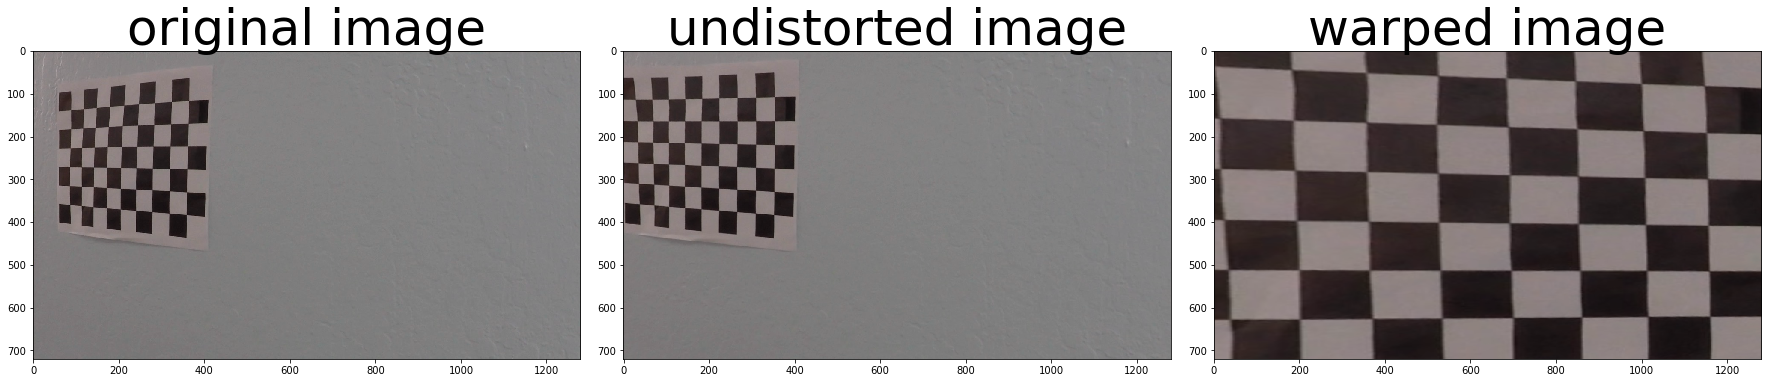

In [8]:
idx = np.random.randint(len(images))

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()

ax1.imshow(images[idx])
ax1.set_title('original image', fontsize=50)

ax2.imshow(udisted_imgs[idx])
ax2.set_title('undistorted image', fontsize=50)

ax3.imshow(warped_imgs[idx])
ax3.set_title('warped image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### Pipeline (test images)


#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one


In [42]:
# Undistort all the image files under `tests_images`folder
out_path = 'output_images/test_images_undistored/'
in_path = 'test_images/'
test_img_files = glob.glob(in_path + '*jpg') + glob.glob(in_path + '*png')
for ifile in test_img_files:
    road_img = cv2.imread(ifile)
    udist = cal_undistort(road_img, obj_points, img_points)
    file_name = ifile.split('/')[-1]
    cv2.imwrite(out_path+file_name, udist)

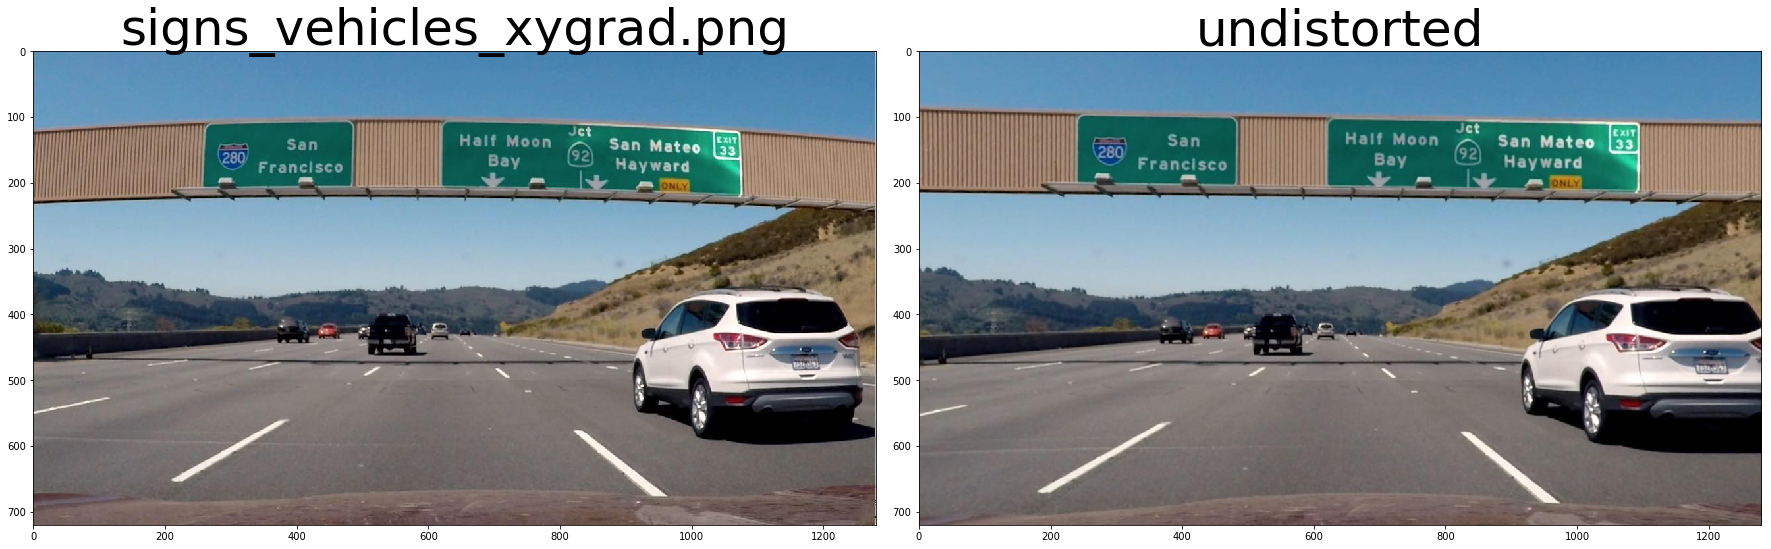

In [47]:
# Show original and undistorted road images side by side
road_img = cv2.imread(in_path + 'signs_vehicles_xygrad.png')
road_img_udist = cv2.imread(out_path + 'signs_vehicles_xygrad.png')

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(road_img, cv2.COLOR_BGR2RGB))
ax1.set_title('signs_vehicles_xygrad.png', fontsize=50)
ax2.imshow(cv2.cvtColor(road_img_udist, cv2.COLOR_BGR2RGB))
ax2.set_title('distortion corrected', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image.
As our interested lanelines in the provided project video are either in yellow or while. To better detect lane lines with those two colors, I found that it is more effective to convert the image into HSV space and set yellow/while thresholds accordingly. 

I also applied a region of interest mast to the binary image to only keep the region contains lane lines. 

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Select while and yellow from hls space 
def select_hls_white_yellow(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    # white color mask
    lower = np.uint8([  0, 200,   0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(hls, lower, upper)
    # yellow color mask
    lower = np.uint8([ 10,   0, 100])
    upper = np.uint8([ 40, 255, 255])
    yellow_mask = cv2.inRange(hls, lower, upper)
    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(image, image, mask = mask)

def binarize_image(img, sx_thresh=(10, 250)):
    img  = np.copy(img)
    img = gaussian_blur(img, 5)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    color_select = select_hls_white_yellow(img)
    # Convert to gray image 
    gray = cv2.cvtColor(color_select, cv2.COLOR_RGB2GRAY)
    ret,gray_binary = cv2.threshold(gray,127,255,cv2.THRESH_BINARY)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(color_select, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx       = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx   = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(gray_binary > 0) | (sxbinary > 0)] = 1
    imshape = img.shape
    vertices = np.array([[ (75,imshape[0]), (450, 450), (775, 450),(1200,imshape[0])]], dtype=np.int32)  
    combined_binary = region_of_interest(combined_binary, vertices)
    # Sanity check the binary image 
    nonzerox = combined_binary.nonzero()[0]
    nonzeroy = combined_binary.nonzero()[1]
    if len(nonzerox) < 2 or len(nonzeroy) < 2:
        print('nonzerox ' + str(len(nonzerox)) + ' nonzeroy ' + str(len(nonzeroy)))
        return None
    else:
        return combined_binary

#### An example of binary image 


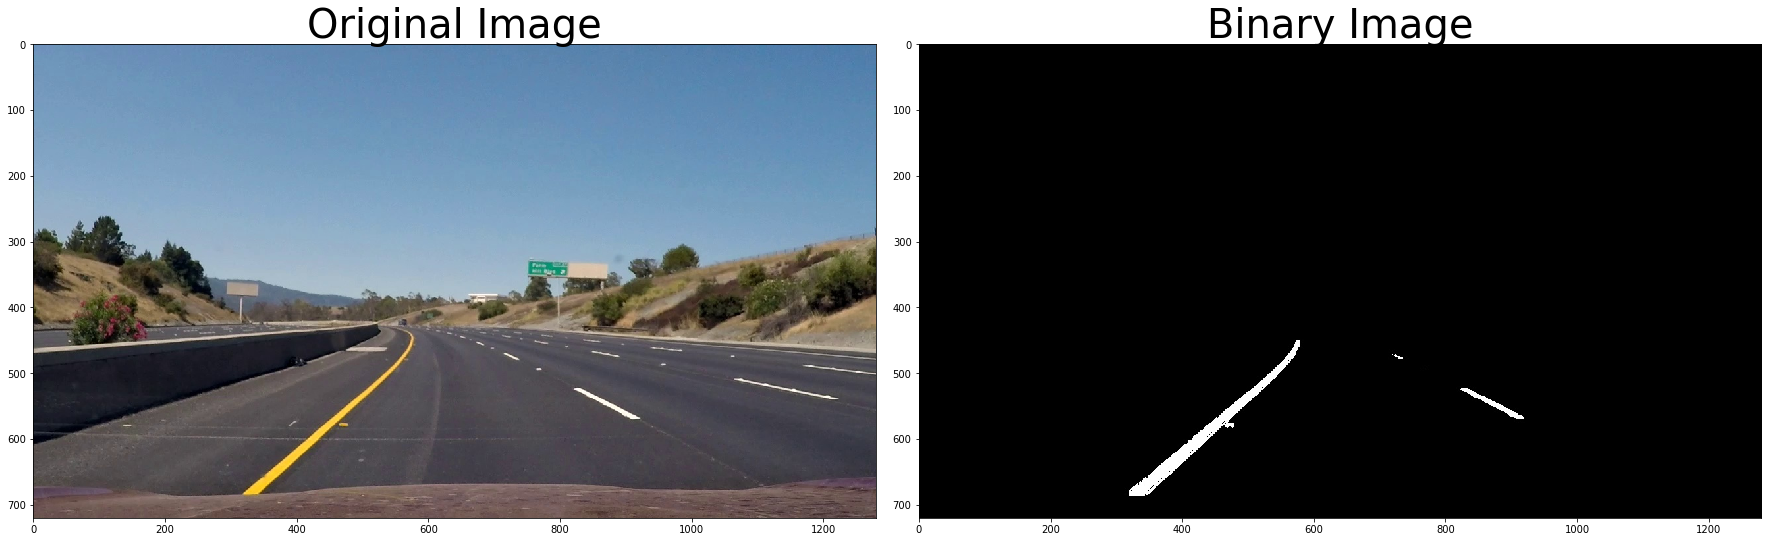

In [10]:
org_img_f = 'writeup_imgs/orginal_frame_0.jpg'
binary_img_f = 'writeup_imgs/binary_frame_0.jpg'
image = cv2.cvtColor(cv2.imread(org_img_f), cv2.COLOR_BGR2RGB) 
binary = cv2.imread(binary_img_f)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary)
ax2.set_title('Binary Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image

The code for my perspective transform is called `perspective_transform()` in my `lane_detect_helper.py`.   

The `perspective_transform()` function takes as inputs an image (`img`). The `src` and `dst` points are hardcoded for this project video.

```python
    src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
    dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])
```

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.


In [11]:
def perspective_transform(image):
    src = np.float32([[(200, 720), (570, 470), (720, 470), (1130, 720)]])
    dst = np.float32([[(350, 720), (350, 0), (980, 0), (980, 720)]])
    M     = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    img_size = image.shape[:2][::-1]
    return cv2.warpPerspective(image, M, img_size , flags=cv2.INTER_LINEAR), M_inv

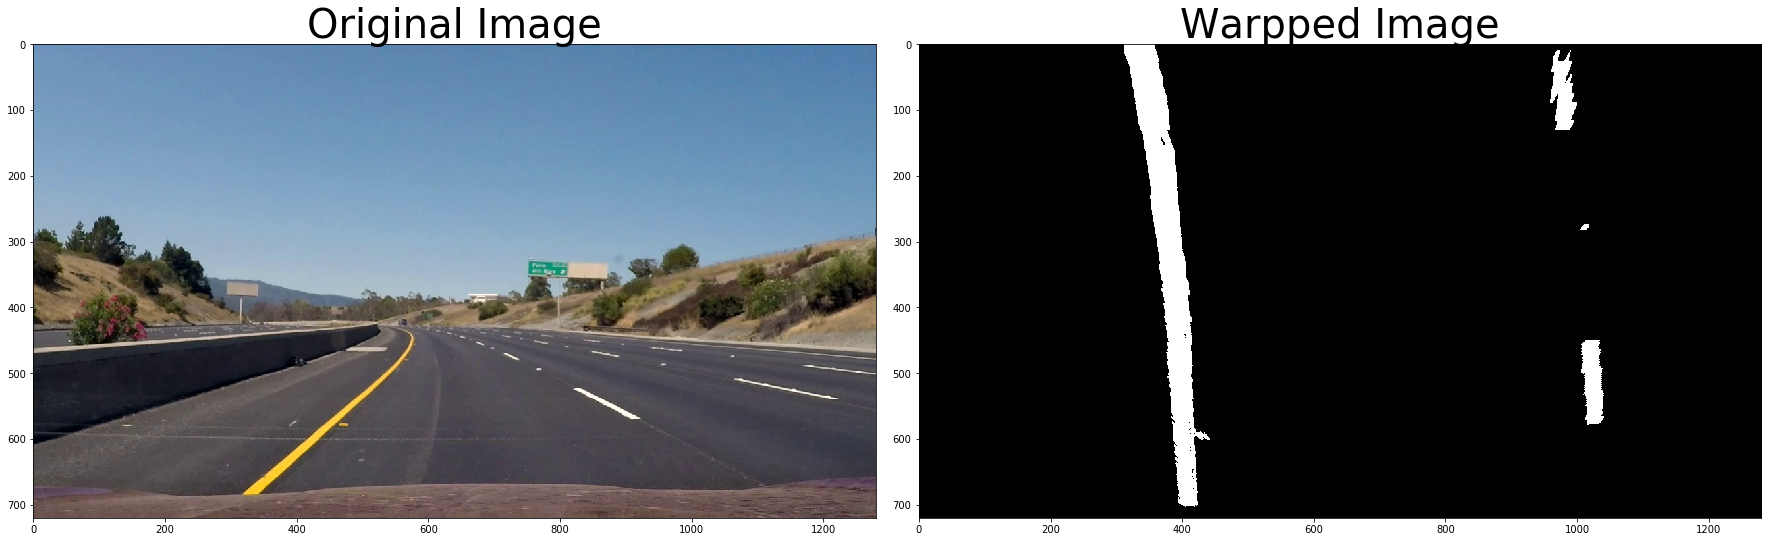

In [12]:
org_img_f = 'writeup_imgs/orginal_frame_0.jpg'
binary_img_f = 'writeup_imgs/warped_frame_0.jpg'
image = cv2.cvtColor(cv2.imread(org_img_f), cv2.COLOR_BGR2RGB) 
binary = cv2.imread(binary_img_f)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(binary)
ax2.set_title('Warpped Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?


I am using the sliding window search to indentify lane-line pixels. The source code is as in below code cell.
 
 * sliding window search to find pixels possible below to left/right lane-line (`left_lane_inds` and `right_lane_inds`)
 * extract the x,y index value (`leftx`, `lefty`  and `rightx`, `righty`)from `left_lane_inds` and `right_lane_inds`
 * perform 2nd order polynominal fit to find the 2nd order polynomial coefficients A, B and C for left and right lane-lines. Results are stored inside `left_fit` and `right_fit`
 
\begin{equation*}
f(y) = Ay^2  + By + C
\end{equation*}



In [42]:
def sliding_window_search(binary_warped):
    left_fit  = None
    right_fit = None
#     if binary_warped is None:
#         return left_fit, right_fit
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint    = np.int(histogram.shape[0]/2)
    leftx_base  = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows    = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current  = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds  = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low       = binary_warped.shape[0] - (window+1)*window_height
        win_y_high      = binary_warped.shape[0] - window*window_height
        win_xleft_low   = leftx_current  - margin
        win_xleft_high  = leftx_current  + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds  = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))

        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds  = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    if len(leftx) > 0 and len(lefty) > 0:
        left_fit  = np.polyfit(lefty,  leftx,  2)
    if len(rightx) > 0 and len(righty) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit, left_lane_inds, right_lane_inds


Above sliding window search is quite expensive. However, if we already found a good fit in previous image, it would be unnecessary to do above search on every new image. 
It is reasonable to assume that the the laneline of current image will be more or less close the the fitted line of previous image. Here, I assume that the current laneline will be within 100 pixels window of previous line. 

In [28]:
# use line fit results from previous image to fit current image
def sliding_window_use_prev_fits(binary_warped, prev_left_fit, prev_right_fit):
    left_fit  = None
    right_fit = None
    if binary_warped is None:
        return left_fit, right_fit

    nonzero  = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin   = 100
    
    left_fit  = prev_left_fit
    right_fit = prev_right_fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx  = nonzerox[left_lane_inds]
    lefty  = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    left_fit  = None
    right_fit = None
    # Fit a second order polynomial to for left/right pixel positions
    if len(leftx) > 0: 
        left_fit  = np.polyfit(lefty, leftx, 2)
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit

#### Example of polynomial fit

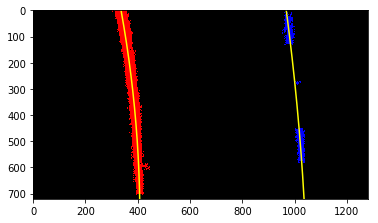

In [43]:
binary_img_f = 'writeup_imgs/warped_frame_0.jpg'
binary_warped = cv2.imread(binary_img_f, cv2.IMREAD_GRAYSCALE)
left_fit, right_fit, left_lane_inds, right_lane_inds = sliding_window_search(binary_warped)

nonzero  = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.
Member function `_calculate_curvance` of `Lanedetecor` is to calculate the curvature of the lane and position of the vehicle.

In [45]:
def _calculate_curvance(self, left_fit, right_fit):
    ploty      = np.linspace(0, self.img_height-1, self.img_height)
    left_fitx  = left_fit[0]*ploty**2  + left_fit[1]*ploty  + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    y_eval     = np.median(ploty)

    leftx      = left_fitx[::-1]  # Reverse to match top-to-bottom in y
    rightx     = right_fitx[::-1] # Reverse to match top-to-bottom in y

    ym_per_pix = self.ym_per_pix # meters per pixel in y dimension
    xm_per_pix = self.xm_per_pix # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr    = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr   = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad  = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate the vehicle position    
    vehicle_position = abs(640 - ((left_fitx[-1]+right_fitx[-1])/2)) * xm_per_pix

    return left_curverad, right_curverad, vehicle_position

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.


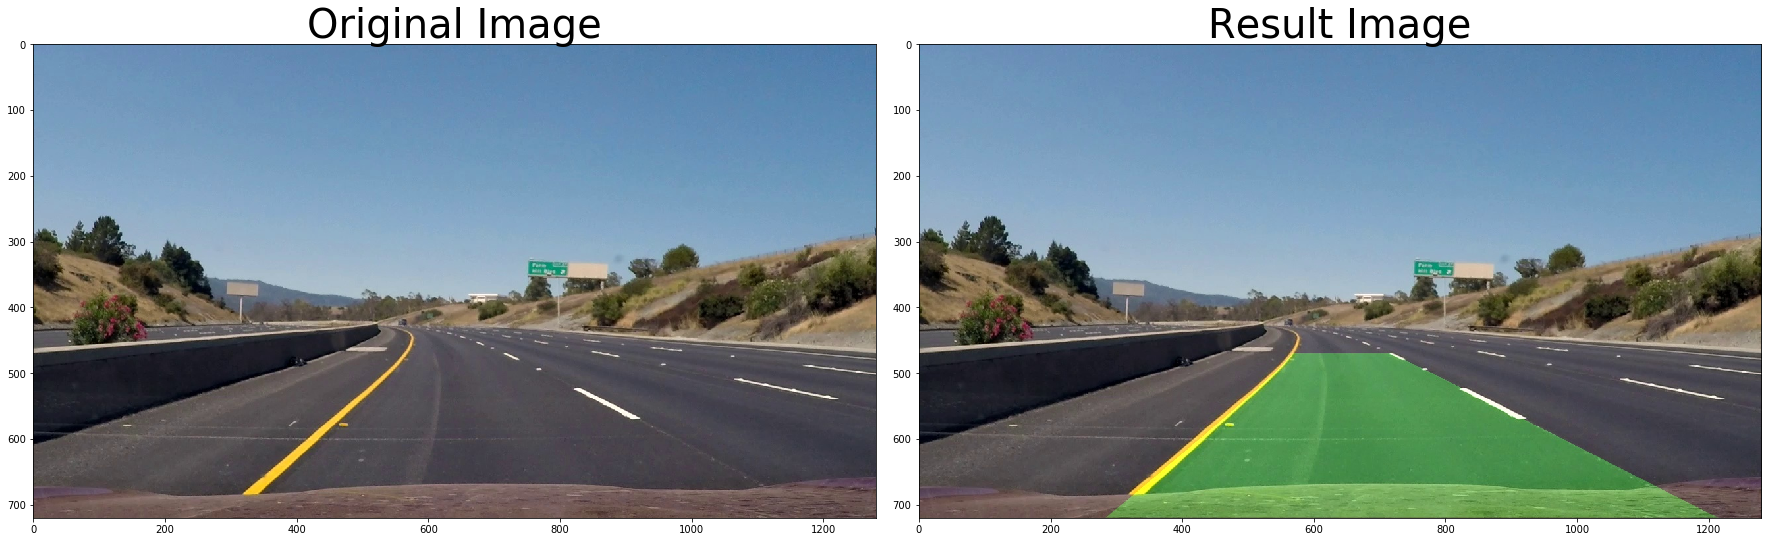

In [47]:
org_img_f = 'writeup_imgs/orginal_frame_0.jpg'
result_f = 'writeup_imgs/processed_frame_0.jpg'
image = cv2.cvtColor(cv2.imread(org_img_f), cv2.COLOR_BGR2RGB) 
result = cv2.cvtColor(cv2.imread(result_f), cv2.COLOR_BGR2RGB) 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(result)
ax2.set_title('Result Image', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).


Here's a [link to my video result](./project_video_out.avi)

Here is my video pipeline. 
* Create a LaneDetector() object
* Call LaneDetector.process(video_file) to start processing 
    * use cv2.VideoCapture() to get each frame from video file
    * call LaneDetector._process_image() to process each image
    * use cv2.VideoWriter() write processed image into a new video file
The full code is in below two files
* `soluton.py`
* `lane_detect_helper.py`

My pipeline will only start brute force sliding window search if there is no fits in prevous iteration. 
After it found a good fit, in the next iteration if will only start search around the neighbours or previous fit. 
The pipeline will also monitor the sanity of current search results, if it detects a too large radius of curvance change compared to fit results from previous image or veichle poistion does not make sense, it will go back brute force sliding window search. 

Also to make the fitting result as soomth as possible, I keep the fit results of past 4 iterations and will use below equation to low pass filter the fit results. 

\begin{equation*}
current\_fit = 0.6 * current\_fit + 0.4 * average\_past\_4\_fits
\end{equation*}



### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

One of the biggest issues I have is the source/destination points for perspecitve transform. In my current implementation, those points are hardcoded and I do not think this is realistic in the real live laneline detection. I did some research on this and it seems that I should use some key points detection algorithm to detect the key points on the original image, however I still have no clue about how to select destination points. 

My current pipeline/algorithm have some issue of dealing with the `challenge_video.mp4` and also `harder_challenge_video.mp4`. I enable the debugging feature of my pipeline, which will dump video frame, binary image and warpped image into jpeg file. From those files, I found that my thresold for binarize image does not seem work very well to the those two videos. Sometimes, there is only a few pixels or nothing for left or right lanes. 

Also my source/destination points for perspective transform seems also failed for challenge videos. I need a better way to decide src/des points other than hardcoded them. I am really interested to know how to select those points or homography matrix for realtime lane-line detection. 
